In [1]:
import psycopg2 as pg2
import pandas as pd

con = pg2.connect(host='localhost', user='postgres', database='postgres', password='passpostgres')
con.autocommit = True
cur = con.cursor()

def select(sql):
    return pd.read_sql(sql,con)

In [2]:
sql = '''select * from uk_retailer_sales a limit 5'''

In [3]:
select(sql)

,index,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
sql = '''
drop table if exists users;
create table users as
select a.customerid, min(date_trunc('month', a.invoicedate)) as reg_month 
from uk_retailer_sales a 
where a.customerid is not null
group by a.customerid'''

In [5]:
cur.execute(sql)

In [6]:
sql = '''select count(*) from users a'''

In [7]:
select(sql)

,count
0,4372


In [8]:
sql = '''select * from d_date a limit 5'''

In [9]:
select(sql)

,date_dim_id,date_actual,epoch,day_suffix,day_name,day_of_week,day_of_month,day_of_quarter,day_of_year,week_of_month,...,last_day_of_week,first_day_of_month,last_day_of_month,first_day_of_quarter,last_day_of_quarter,first_day_of_year,last_day_of_year,mmyyyy,mmddyyyy,weekend_indr
0,19700101,1970-01-01,0,1st,Thursday,4,1,1,1,1,...,1970-01-04,1970-01-01,1970-01-31,1970-01-01,1970-03-31,1970-01-01,1970-12-31,011970,01011970,False
1,19700102,1970-01-02,86400,2nd,Friday,5,2,2,2,1,...,1970-01-04,1970-01-01,1970-01-31,1970-01-01,1970-03-31,1970-01-01,1970-12-31,011970,01021970,False
2,19700103,1970-01-03,172800,3rd,Saturday,6,3,3,3,1,...,1970-01-04,1970-01-01,1970-01-31,1970-01-01,1970-03-31,1970-01-01,1970-12-31,011970,01031970,True
3,19700104,1970-01-04,259200,4th,Sunday,7,4,4,4,1,...,1970-01-04,1970-01-01,1970-01-31,1970-01-01,1970-03-31,1970-01-01,1970-12-31,011970,01041970,True
4,19700105,1970-01-05,345600,5th,Monday,1,5,5,5,1,...,1970-01-11,1970-01-01,1970-01-31,1970-01-01,1970-03-31,1970-01-01,1970-12-31,011970,01051970,False


In [12]:
sql = '''select distinct a.first_day_of_month from d_date a 
where a.date_actual between (select min(date_trunc('month', a.invoicedate)) from uk_retailer_sales a)
and (select max(date_trunc('month', a.invoicedate)) from uk_retailer_sales a)
order by 1'''

In [13]:
select(sql)

,first_day_of_month
0,2010-12-01
1,2011-01-01
2,2011-02-01
3,2011-03-01
4,2011-04-01
5,2011-05-01
6,2011-06-01
7,2011-07-01
8,2011-08-01
9,2011-09-01


In [18]:
sql = '''
drop table if exists user_month_1;
create table user_month_1 as
select * from users a
join (select distinct a.first_day_of_month as month from d_date a 
where a.date_actual between (select min(date_trunc('month', a.invoicedate)) from uk_retailer_sales a)
and (select max(date_trunc('month', a.invoicedate)) from uk_retailer_sales a)) b
on a.reg_month <= b.month
order by b.month
'''

In [19]:
cur.execute(sql)

In [20]:
sql = '''select * from user_month_1 a limit 5'''

In [21]:
select(sql)

,customerid,reg_month,month
0,14506.0,2010-12-01,2010-12-01
1,17191.0,2010-12-01,2010-12-01
2,15468.0,2010-12-01,2010-12-01
3,17404.0,2010-12-01,2010-12-01
4,17181.0,2010-12-01,2010-12-01


In [26]:
sql = '''
drop table if exists sales_month_agg;
create table sales_month_agg as

select a.customerid, date_trunc('month', a.invoicedate) as month, 
count(distinct a.invoiceno) as invoice_count,
sum(a.unitprice * a.quantity) as price_sum

from uk_retailer_sales a
group by a.customerid, date_trunc('month', a.invoicedate)
order by date_trunc('month', a.invoicedate)'''

In [28]:
cur.execute(sql)

In [29]:
sql = '''select * from sales_month_agg a limit 5'''

In [30]:
select(sql)

,customerid,month,invoice_count,price_sum
0,12347.0,2010-12-01,1,711.79
1,12348.0,2010-12-01,1,892.80
2,12370.0,2010-12-01,2,1868.02
3,12377.0,2010-12-01,1,1001.52
4,12383.0,2010-12-01,1,600.72


In [62]:
sql = '''
drop table if exists sales_month;
create table sales_month as

select a.* , b.invoice_count, b.price_sum, 1 as customer,
case when b.invoice_count > 0 then 1 else 0 end as active

from user_month_1 a
left join sales_month_agg b
on a.customerid = b.customerid and a.month = b.month

'''

In [63]:
cur.execute(sql)

In [64]:
sql = '''select * from sales_month a 
where customerid = 12370.0
order by a.month'''

In [65]:
select(sql)

,customerid,reg_month,month,invoice_count,price_sum,customer,active
0,12370.0,2010-12-01,2010-12-01,2.0,1868.02,1,1
1,12370.0,2010-12-01,2011-01-01,NaN,NaN,1,0
2,12370.0,2010-12-01,2011-02-01,NaN,NaN,1,0
3,12370.0,2010-12-01,2011-03-01,1.0,938.39,1,1
4,12370.0,2010-12-01,2011-04-01,NaN,NaN,1,0
5,12370.0,2010-12-01,2011-05-01,NaN,NaN,1,0
6,12370.0,2010-12-01,2011-06-01,NaN,NaN,1,0
7,12370.0,2010-12-01,2011-07-01,NaN,NaN,1,0
8,12370.0,2010-12-01,2011-08-01,NaN,NaN,1,0
9,12370.0,2010-12-01,2011-09-01,NaN,NaN,1,0


In [69]:
sql = '''select a.month, sum(a.customer) as cust_count,
sum(a.invoice_count) as invoice,
sum(a.price_sum) as revenue,
sum(a.active) as active,
sum(a.active) * 1.0 / sum(a.customer) as active_pct

from sales_month a 
group by a.month
order by a.month'''

In [71]:
df = select(sql)

In [72]:
df

,month,cust_count,invoice,revenue,active,active_pct
0,2010-12-01,948,1708.0,554604.020,948,1.000000
1,2011-01-01,1369,1236.0,475074.380,783,0.571950
2,2011-02-01,1749,1202.0,436546.150,798,0.456261
3,2011-03-01,2189,1619.0,579964.610,1020,0.465966
4,2011-04-01,2488,1384.0,426047.851,899,0.361334
5,2011-05-01,2767,1849.0,648251.080,1079,0.389953
6,2011-06-01,3002,1707.0,608013.160,1051,0.350100
7,2011-07-01,3193,1593.0,574238.481,993,0.310993
8,2011-08-01,3360,1544.0,616368.000,980,0.291667
9,2011-09-01,3658,2078.0,931440.372,1302,0.355932


In [73]:
%matplotlib inline

<AxesSubplot:>

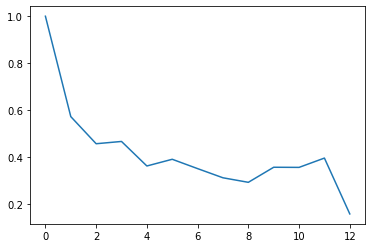

In [74]:
df['active_pct'].plot()

<AxesSubplot:>

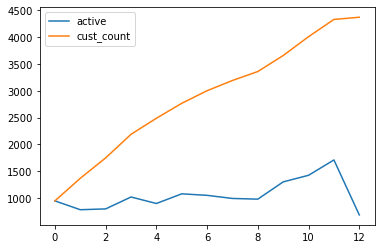

In [75]:
df[['active', 'cust_count']].plot()